## Login HuggingFace


In [1]:
from google.colab import userdata
hf_token = userdata.get("HUGGINGFACE_TOKEN")
from huggingface_hub import login
login(token=hf_token)

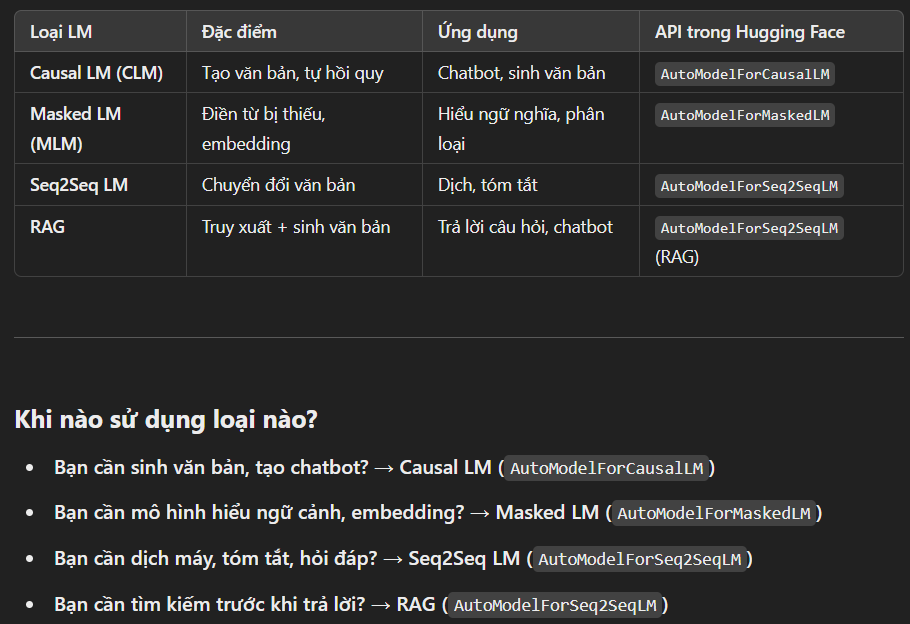

In [2]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

model_path = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype = torch.bfloat16,   # bfloat16 duy trì độ chính xác tốt hơn float16 trong khi tiết kiệm bộ nhớ
    device_map = "auto",            # tự quyết định device CPU/GPU phù hợp
    trust_remote_code = True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

## Set Padding
- 1 số Một số tokenizer (ví dụ: GPT-2, LLaMA) không có pad_token mặc định, vì chúng được thiết kế để xử lý văn bản liên tục mà không cần padding
- Giúp mô hình không gặp lỗi batch khi văn bản độ dài không đều

In [3]:
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = "right"

# Apply Template

In [4]:
def simple_prompt(messages, tokenizer, model):
  """
    @param messages: messages list
    @param tokenizer: tokenizer
    @param model: model

    @return answer
  """
  # Chuyển các messages về cấu trúc hội thoại mà model có thể hiểu và chuyển về tensor phù hợp với model
  model_inputs = tokenizer.apply_chat_template(messages, return_tensors="pt")
  model_inputs = model_inputs.to("cuda")
  # Tạo ra văn bản dựa trên đầu vào
  generate_ids = model.generate(
      model_inputs,
      pad_token_id = tokenizer.pad_token_id,
      do_sample = True,                       # Sử dụng Sampling
      max_new_tokens = 1000
  )

  decoded = tokenizer.batch_decode(generate_ids)
  # Lấy kết quả đầu tiên trong danh sách kết quả
  return decoded[0]

In [16]:
def simple_chat(tokenizer, model):
    user_input = None
    immediate_context = []
    while user_input != "bye": # end chat with bye message
        message = {"role": "user", "content": f"{user_input}"}

        if user_input == None:
            print('-'*103)
            user_input = input("| You |\n-------\n")
            continue
        immediate_context.append(message) # update chat history

        res = simple_prompt(immediate_context, tokenizer, model)

        answer = res.split('[/INST]')[-1].strip('</s>').strip()

        print('-'*103)
        padding = ' ' * 91
        el_id = 103
        print_answer = answer

        while len(print_answer) > el_id:
          print_answer = print_answer[:el_id] + '\n' + print_answer[el_id:]
          el_id += 103

        print(padding, " | Model |\n", padding, "---------\n", print_answer)

        response = {"role":"assistant", "content": f"{answer}"}
        immediate_context.append(response) # update chat history

        print('-'*103)
        user_input = input("| You |\n-------\n")
    print('-'*103)

In [17]:
simple_chat(tokenizer, model)

-------------------------------------------------------------------------------------------------------
| You |
-------
Hello
-------------------------------------------------------------------------------------------------------
                                                                                             | Model |
                                                                                             ---------
 Hello there! How can I help you today? Is there something specific you would like to talk about or ask?
 I'm here to assist you with questions, provide information, or just chat if you'd like.
-------------------------------------------------------------------------------------------------------
| You |
-------
Tell me about DeepSeek
-------------------------------------------------------------------------------------------------------
                                                                                             | Model |
                    